In [1]:
# 주식 종목 불러오는 패키지
!pip install finance-datareader

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.3/89.3 kB 6.6 MB/s eta 0:00:00


In [2]:
import FinanceDataReader as fdr

# 삼성전자

In [3]:
# 삼성전자로 세팅됨, 종목번호 및 기간 바꿔서 진행
df = fdr.DataReader('005930', '2024-01-01', '2025-12-31')
df.tail()

,Open,High,Low,Close,Volume,Change
Date,,,,,,
2025-01-16,54200,55000,54100,54300,18627298,0.011173
2025-01-17,53800,54100,53200,53700,18805344,-0.011050
2025-01-20,53600,53900,53300,53400,11822531,-0.005587
2025-01-21,53700,54300,53300,53500,13535702,0.001873
2025-01-22,53400,54400,53100,54300,18175738,0.014953


# 분석 코드

In [4]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import seaborn as sns

In [5]:
# GPU 꼭 연결해서 사용하세요~!
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda', index=0)

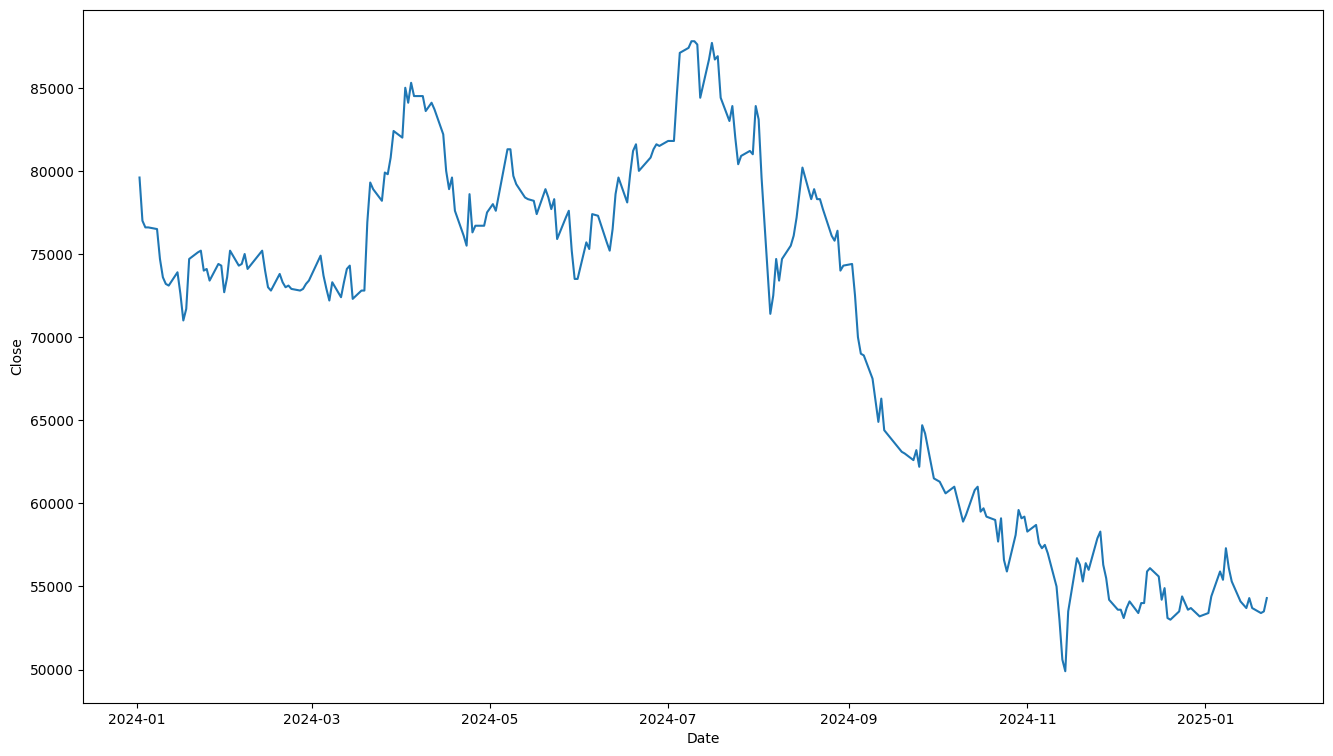

In [6]:
plt.figure(figsize=(16, 9))
sns.lineplot(x=df.index, y='Close', data=df)
plt.show()

# 데이터 전처리

In [7]:
#종가 제외 스케일링 (예측변수 = 종가)
scaler = MinMaxScaler()
df[['Open', 'High', 'Low', 'Close', 'Volume']] = scaler.fit_transform(df[['Open','High', 'Low','Close','Volume']])

In [8]:
#넘파이 배열로 변경
x = df[['Open', 'High', 'Low', 'Volume']].values
y = df['Close'].values

#시퀀스 데이터 생성
def seq_data(x, y, sequence_length):
  x_seq = []
  y_seq = []
  for i in range(len(x) - sequence_length):
    x_seq.append(x[ i : i + sequence_length])
    y_seq.append(y[i + sequence_length])

  #gpu용 텐서로 변환
  return torch.FloatTensor(x_seq).to(device), torch.FloatTensor(y_seq).to(device).view(-1,1)

In [9]:
split = 200
sequence_length=5 # 5일치씩 묶기
x_seq, y_seq = seq_data(x, y, sequence_length)

#순서대로 70개는 학습, 나머지는 평가
x_train_seq = x_seq[:split]
y_train_seq = y_seq[:split]

x_test_seq = x_seq[split:]
y_test_seq = y_seq[split:]

print(x_train_seq.size(), y_train_seq.size())
print(x_test_seq.size(), y_test_seq.size())

torch.Size([200, 5, 4]) torch.Size([200, 1])
torch.Size([54, 5, 4]) torch.Size([54, 1])


<ipython-input-8-650847349e00>:14: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:278.)
  return torch.FloatTensor(x_seq).to(device), torch.FloatTensor(y_seq).to(device).view(-1,1)


In [10]:
x_train_seq

tensor([[[0.7311, 0.7568, 0.7608, 0.1872],
         [0.7389, 0.7297, 0.7285, 0.2796],
         [0.6762, 0.6892, 0.7043, 0.1507],
         [0.6919, 0.6838, 0.7124, 0.0701],
         [0.6997, 0.6946, 0.7124, 0.0658]],

        [[0.7389, 0.7297, 0.7285, 0.2796],
         [0.6762, 0.6892, 0.7043, 0.1507],
         [0.6919, 0.6838, 0.7124, 0.0701],
         [0.6997, 0.6946, 0.7124, 0.0658],
         [0.7102, 0.7000, 0.6559, 0.3651]],

        [[0.6762, 0.6892, 0.7043, 0.1507],
         [0.6919, 0.6838, 0.7124, 0.0701],
         [0.6997, 0.6946, 0.7124, 0.0658],
         [0.7102, 0.7000, 0.6559, 0.3651],
         [0.6475, 0.6324, 0.6263, 0.2496]],

        ...,

        [[0.2089, 0.1811, 0.1801, 0.4750],
         [0.1514, 0.1378, 0.1586, 0.3613],
         [0.1436, 0.1811, 0.1559, 0.4003],
         [0.2037, 0.2108, 0.1989, 0.4122],
         [0.2324, 0.2162, 0.2339, 0.2412]],

        [[0.1514, 0.1378, 0.1586, 0.3613],
         [0.1436, 0.1811, 0.1559, 0.4003],
         [0.2037, 0.2108, 0.1989

In [11]:
train = torch.utils.data.TensorDataset(x_train_seq, y_train_seq)
test = torch.utils.data.TensorDataset(x_test_seq, y_test_seq)

batch_size = 5
train_loader = torch.utils.data.DataLoader(dataset=train, batch_size = batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test, batch_size = batch_size)

# Vanila RNN
## 모델 구축

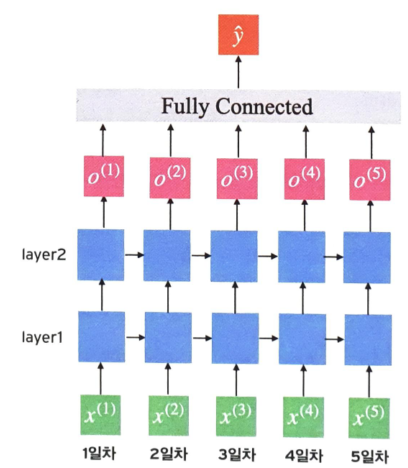

In [12]:
#기본 하이퍼 파라미터 설정
input_size = x_seq.size(2)
num_layers = 2
hidden_size = 8

In [13]:
class VanillaRNN(nn.Module):
  def __init__(self, input_size, hidden_size, sequence_length, num_layers, device):
    super(VanillaRNN, self).__init__()
    self.device = device
    self.hidden_size = hidden_size
    self.num_layers = num_layers
    self.rnn = nn.RNN(input_size, hidden_size, num_layers, batch_first=True) #한 줄로 모델 정의
    self.fc = nn.Sequential(nn.Linear(hidden_size * sequence_length, 1), nn.Sigmoid()) #RNN 층에서 나온 결과를 fc 층으로 전달해서 예측값 계산

  def forward(self, x):
    h0 = torch.zeros(self.num_layers, x.size()[0], self.hidden_size).to(self.device) #초기값 0으로 설정
    out,_ = self.rnn(x, h0)
    out = out.reshape(out.shape[0], -1)
    out = self.fc(out)
    return out

In [14]:
model = VanillaRNN(input_size=input_size,
                   hidden_size = hidden_size,
                   sequence_length=sequence_length,
                   num_layers=num_layers,
                   device=device).to(device)

In [15]:
criterion = nn.MSELoss()
num_epochs = 50
optimizer = optim.Adam(model.parameters(), lr=1e-3)

## 모델 학습

In [16]:
loss_graph = []
n = len(train_loader)

for epoch in range(num_epochs):
  running_loss = 0

  for data in train_loader:
    seq, target = data #배치 데이터
    out = model(seq) #출력값 계산
    loss = criterion(out, target) #손실함수 계산

    optimizer.zero_grad()
    loss.backward()
    optimizer.step() #최적화
    running_loss += loss.item()

  loss_graph.append(running_loss/n)
  if epoch % 10 ==0:
    print('[epoch : %d] loss: %.4f' %(epoch, running_loss/n))

[epoch : 0] loss: 0.0423
[epoch : 10] loss: 0.0049
[epoch : 20] loss: 0.0042
[epoch : 30] loss: 0.0038
[epoch : 40] loss: 0.0034


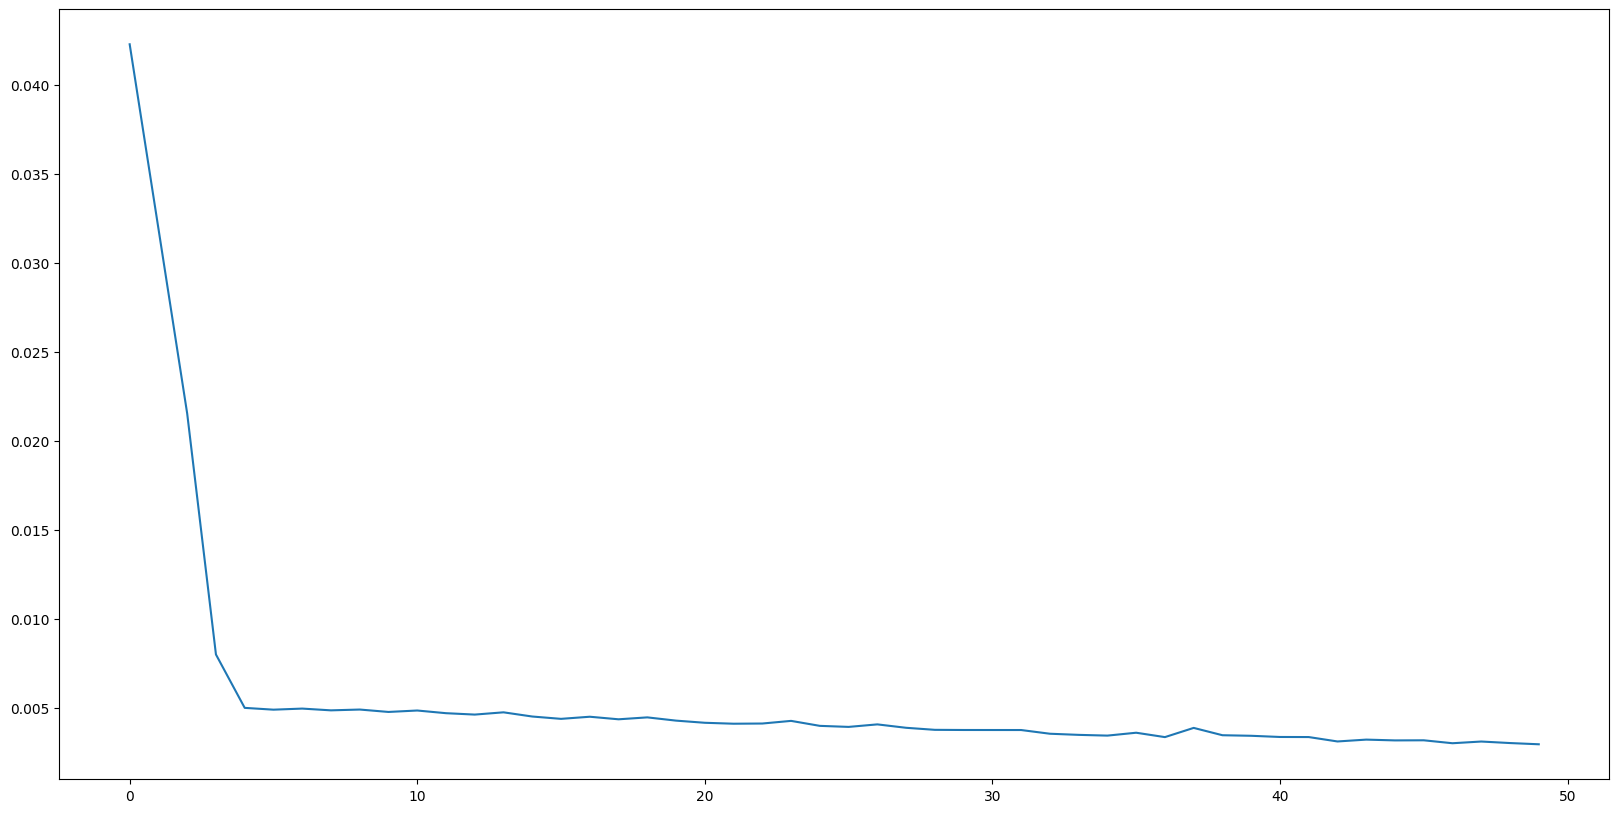

In [17]:
plt.figure(figsize=(20,10))
plt.plot(loss_graph)
plt.show()

## 실제값과 예측값 비교

In [18]:
concatdata = torch.utils.data.ConcatDataset([train, test])
data_loader = torch.utils.data.DataLoader(dataset = concatdata, batch_size = 100)

with torch.no_grad():
  pred = []
  model.eval()
  for data in data_loader:
    seq, target = data
    out = model(seq)
    pred += out.cpu().tolist()

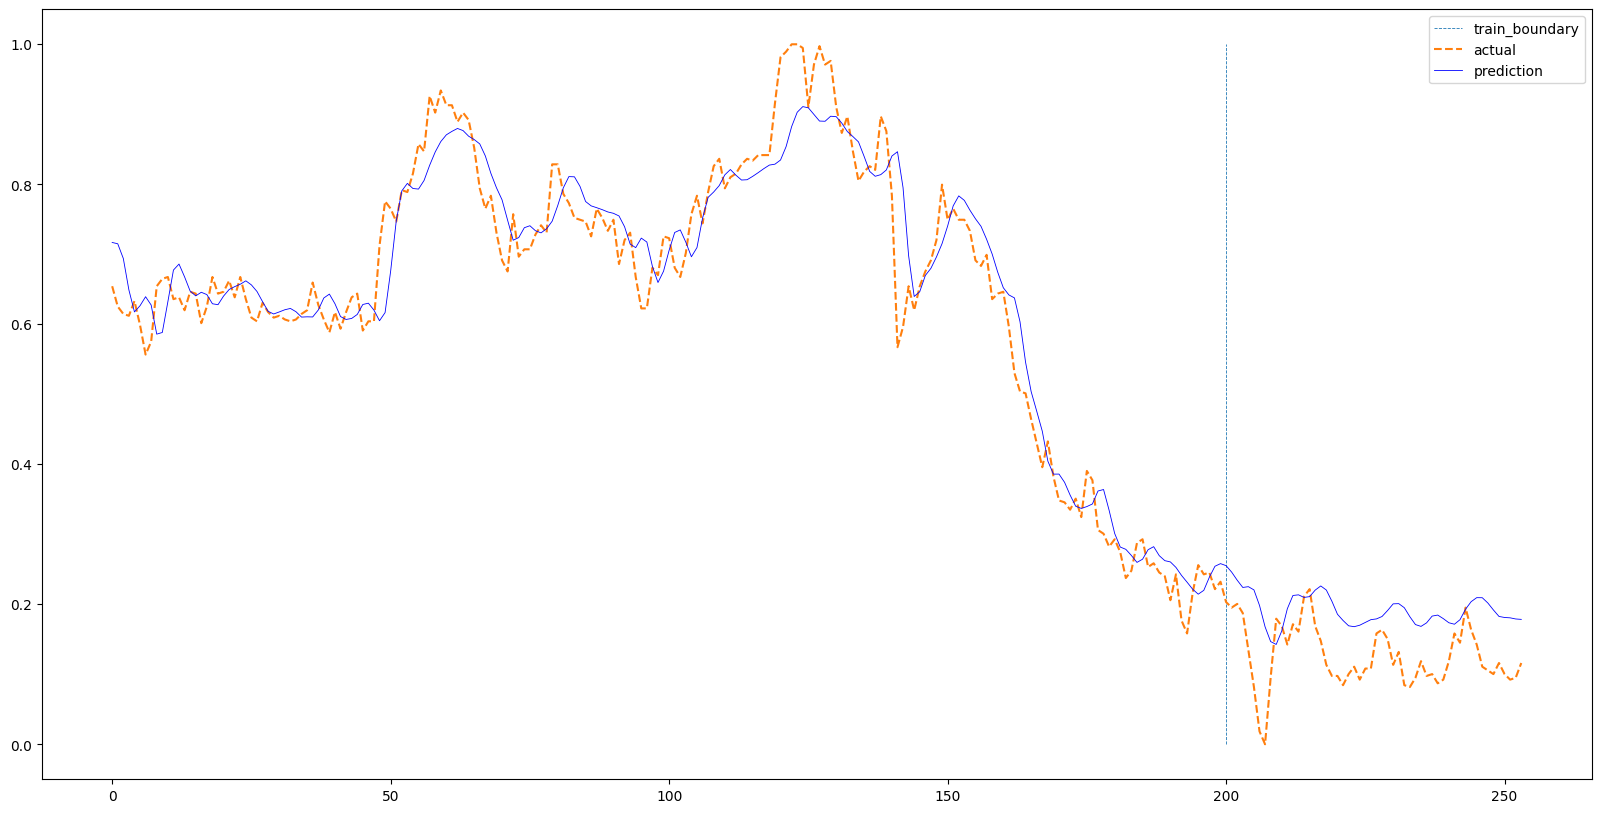

In [19]:
plt.figure(figsize = (20,10))
plt.plot(np.ones(100)*len(train), np.linspace(0,1,100), '--', linewidth=0.6)
plt.plot(df['Close'][sequence_length:].values,'--')
plt.plot(pred, 'b', linewidth = 0.6)
plt.legend(['train_boundary','actual','prediction'])
plt.show()

# LSTM
## 모델구축

In [20]:
#하이퍼 파라미터 정의
input_size = x_seq.size(2)
num_layers = 2
hidden_size = 8

In [21]:
class LSTM(nn.Module):
  def __init__(self, input_size, hidden_size, sequence_length, num_layers, device):
    super(LSTM, self).__init__()
    self.device = device
    self.hidden_size = hidden_size
    self.num_layers = num_layers
    self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first = True)
    self.fc = nn.Linear(hidden_size*sequence_length ,1)

  def forward(self, x):
    h0 = torch.zeros(self.num_layers, x.size()[0], self.hidden_size).to(self.device)
    c0 = torch.zeros(self.num_layers, x.size()[0], self.hidden_size).to(self.device)
    out, _ = self.lstm(x,(h0,c0))
    out = out.reshape(out.shape[0], -1)
    out = self.fc(out)
    return out

In [22]:
model = LSTM(input_size = input_size,
             hidden_size=hidden_size,
             sequence_length=sequence_length,
             num_layers = num_layers,
             device=device).to(device)

In [23]:
criterion = nn.MSELoss()
num_epochs =50
optimizer = optim.Adam(model.parameters(), lr=1e-3)

In [24]:
loss_graph = []
n = len(train_loader)

for epoch in range(num_epochs):
    running_loss = 0.0

    for data in train_loader:

        seq, target = data # 배치 데이터
        out = model(seq)
        loss = criterion(out, target)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    loss_graph.append(running_loss/n)
    if epoch % 10 == 0:
        print('[epoch: %d] loss: %.4f' %(epoch, running_loss/n))


[epoch: 0] loss: 0.2014
[epoch: 10] loss: 0.0050
[epoch: 20] loss: 0.0046
[epoch: 30] loss: 0.0044
[epoch: 40] loss: 0.0042


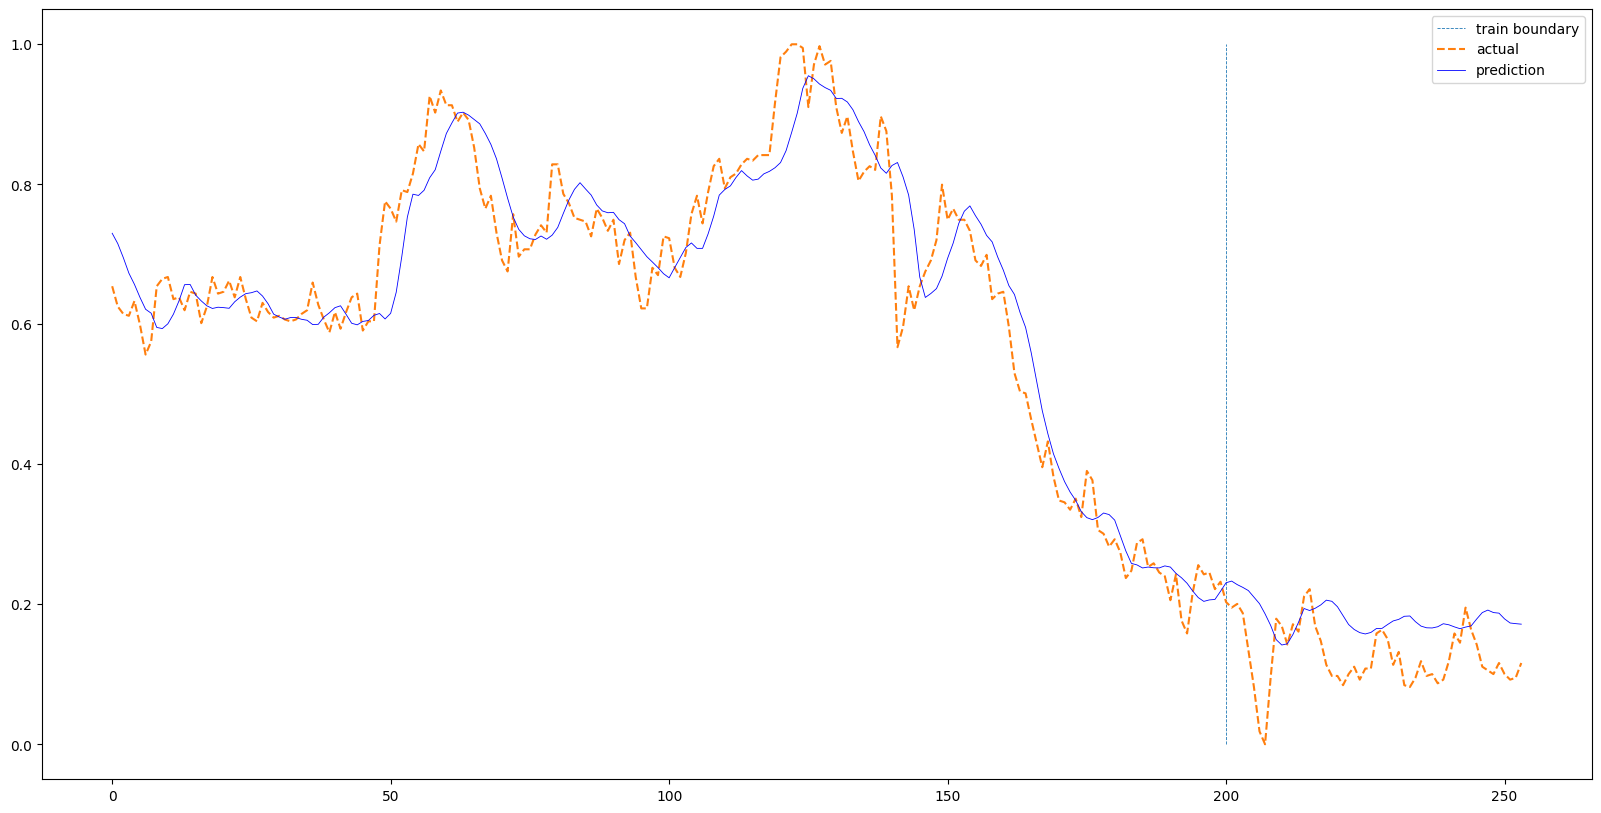

In [25]:
concatdata = torch.utils.data.ConcatDataset([train, test])
data_loader = torch.utils.data.DataLoader(dataset=concatdata, batch_size=100, shuffle=False)

with torch.no_grad():
    pred = []
    model.eval()
    for data in data_loader:
        seq, target = data
        out = model(seq)
        pred += out.cpu().tolist()

plt.figure(figsize=(20,10))
plt.plot(np.ones(100)*len(train),np.linspace(0,1,100),'--', linewidth=0.6)
plt.plot(df['Close'][sequence_length:].values,'--')
plt.plot(pred,'b', linewidth=0.6)
plt.legend(['train boundary','actual','prediction'])
plt.show()

# (Optional)

현대 자동차 주가에 대한 정보에 같은 분석을 해봅시다. 다음 코드를 한 번 실행한 뒤, 분석 코드부터 다시 그대로 돌려보시기 보고 결과에 대해 자유롭게 해석해보시기 바랍니다.

In [26]:
# 현대자동자 주가로 세팅됨, 종목번호 및 기간 바꿔서 진행
df = fdr.DataReader('005380', '2024-01-01', '2025-12-31')
df.tail

<bound method NDFrame.tail of               Open    High     Low   Close  Volume    Change
Date                                                        
2024-01-02  202000  202500  199800  200500  373050 -0.014742
2024-01-03  199100  199500  193800  193800  548675 -0.033416
2024-01-04  192000  192800  189100  190000  505979 -0.019608
2024-01-05  190100  190500  187200  187300  440219 -0.014211
2024-01-08  187600  188900  185500  185700  323498 -0.008542
...            ...     ...     ...     ...     ...       ...
2025-01-16  223000  224000  218000  219000  435312 -0.006803
2025-01-17  217500  218000  211000  211500  813817 -0.034247
2025-01-20  211000  212000  207500  208500  571176 -0.014184
2025-01-21  210500  213000  206500  206500  833996 -0.009592
2025-01-22  207500  210000  206500  208500  829006  0.009685

[259 rows x 6 columns]>